In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## 1. Load Data

In [2]:
input_path = Path("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/attention_speech_len.parquet")
df = pd.read_parquet(input_path)

top_words_path = Path("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/unique_top_words.parquet")
words_df = pd.read_parquet(top_words_path)

logodds_path = Path("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/terms_logodds.parquet")
logodds_df = pd.read_parquet(logodds_path)

df.head()

,year,decade,month,reference_date,chamber,title,topic,debate_id,speaker,gender,...,observed_turns,expected_words_gender,norm_words_speaker,expected_words_flat,flat_norm_words,avg_words_per_turn,expected_avg_words_per_turn,norm_avg_words_per_turn,group_norm_words,row_type
0,1944,1940,jan,18 January 1944,Commons,Pensioned Civil Servants (Re-employment) (Hans...,Pensioned Civil Servants (Re-employment),0000306c599d8b97,COMMANDER GALBRAITH,M,...,1.0,9.0,0.888889,4.5,1.777778,8.0,4.500000,1.777778,NaN,speaker
1,1944,1940,jan,18 January 1944,Commons,Pensioned Civil Servants (Re-employment) (Hans...,Pensioned Civil Servants (Re-employment),0000306c599d8b97,MR. ASSHETON,M,...,1.0,9.0,0.111111,4.5,0.222222,1.0,4.500000,0.222222,NaN,speaker
2,2002,2000,nov,26 November 2002,Commons,"Scottish Parliament (Hansard, 26 November 2002)",Scottish Parliament,00004c52312f0124,MR. BARON,M,...,1.0,136.0,0.169118,34.0,0.676471,23.0,22.666667,1.014706,NaN,speaker
3,2002,2000,nov,26 November 2002,Commons,"Scottish Parliament (Hansard, 26 November 2002)",Scottish Parliament,00004c52312f0124,MR. ERNIE ROSS,M,...,1.0,136.0,0.110294,34.0,0.441176,15.0,22.666667,0.661765,NaN,speaker
4,2002,2000,nov,26 November 2002,Commons,"Scottish Parliament (Hansard, 26 November 2002)",Scottish Parliament,00004c52312f0124,MR. PETER DUNCAN,M,...,1.0,136.0,0.169118,34.0,0.676471,23.0,22.666667,1.014706,NaN,speaker


In [3]:
speaker_df = df[df["speaker"].notna()].copy()
group_df = df[df["speaker"].isna()].copy()

## 2. Basic Checks

In [4]:
print(speaker_df.shape)
print(speaker_df["gender"].value_counts())
print(f"# Unique speakers {speaker_df['speaker'].nunique()}")
print(f"# Unique male speakers {df.loc[df['gender'] == 'M', 'speaker'].nunique()}")
print(f"# Unique female speakers {df.loc[df['gender'] == 'F', 'speaker'].nunique()}")

(1143309, 21)
gender
M    1110287
F      33022
Name: count, dtype: int64
# Unique speakers 20370
# Unique male speakers 19757
# Unique female speakers 628


## 3. Speaker-Level Normalization

### 3.1 Distribution of Normalized Words by Gender

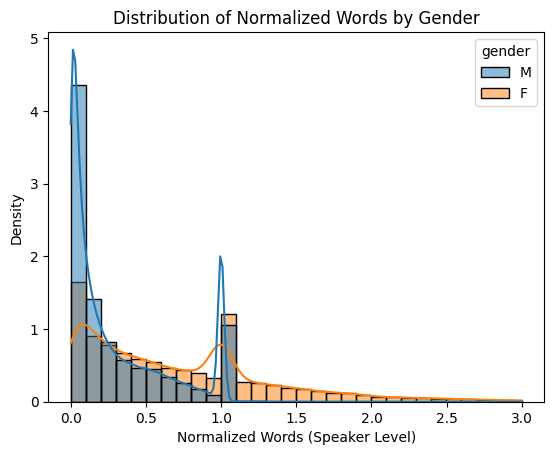

In [5]:
sns.histplot(
    data=speaker_df[speaker_df["norm_words_speaker"] < 3],  # example cap
    x="norm_words_speaker",
    hue="gender",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Distribution of Normalized Words by Gender")
plt.xlabel("Normalized Words (Speaker Level)")
plt.ylabel("Density")
plt.show()

### 3.2 Speaker-level Normalized Word Share by Gender

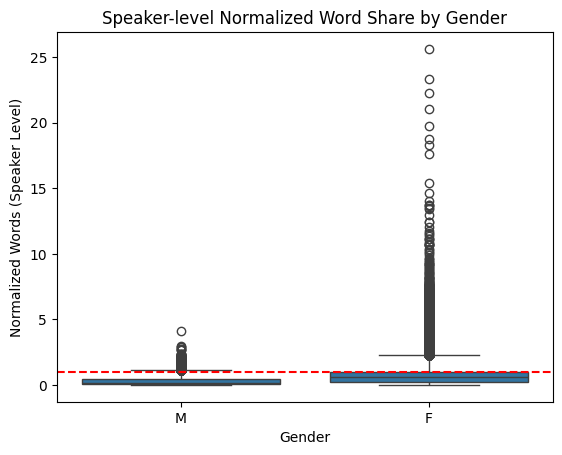

In [6]:
sns.boxplot(x="gender", y="norm_words_speaker", data=speaker_df[speaker_df["speaker"].notna()])
plt.title("Speaker-level Normalized Word Share by Gender")
plt.xlabel("Gender")
plt.ylabel("Normalized Words (Speaker Level)")
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.show()

### 3.3 Share of words over time (speaker-level mean)

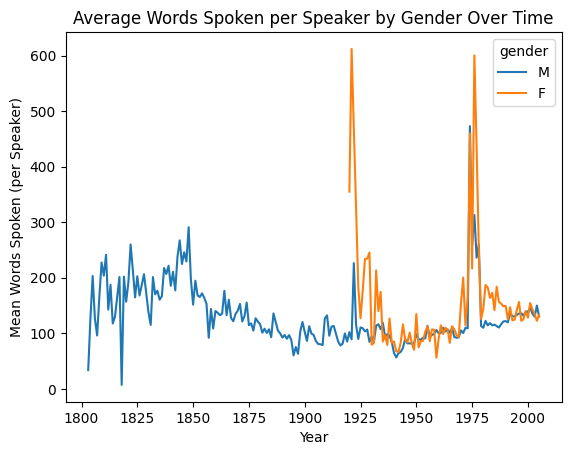

In [7]:
if "year" in speaker_df.columns:
    df_yearly_speaker = (
        speaker_df.groupby(["year", "gender"])["observed_words"]
        .mean()
        .reset_index()
    )

    sns.lineplot(x="year", y="observed_words", hue="gender", data=df_yearly_speaker)
    plt.title("Average Words Spoken per Speaker by Gender Over Time")
    plt.xlabel("Year")
    plt.ylabel("Mean Words Spoken (per Speaker)")
    plt.show()

### 3.4 Average Normalized Turns by Gender

/var/folders/0m/grfzmmms0559g5xz0whbn8180000gn/T/ipykernel_57019/2143486240.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_by_gender, x="gender", y="norm_words_speaker", palette="pastel")
/var/folders/0m/grfzmmms0559g5xz0whbn8180000gn/T/ipykernel_57019/2143486240.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


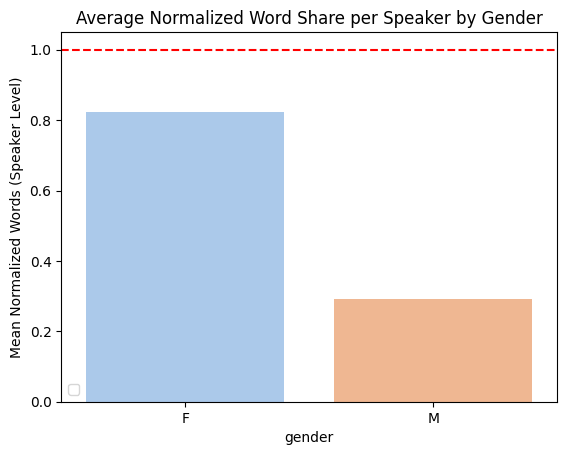

In [8]:
avg_by_gender = speaker_df.groupby("gender")["norm_words_speaker"].mean().reset_index()

sns.barplot(data=avg_by_gender, x="gender", y="norm_words_speaker", palette="pastel")
plt.title("Average Normalized Word Share per Speaker by Gender")
plt.ylabel("Mean Normalized Words (Speaker Level)")
plt.axhline(1, color="red", linestyle="--")
plt.legend()
plt.show()

## 4. Group-Level Normalization

### 4.1 Group-level Normalized Word Share by Gender

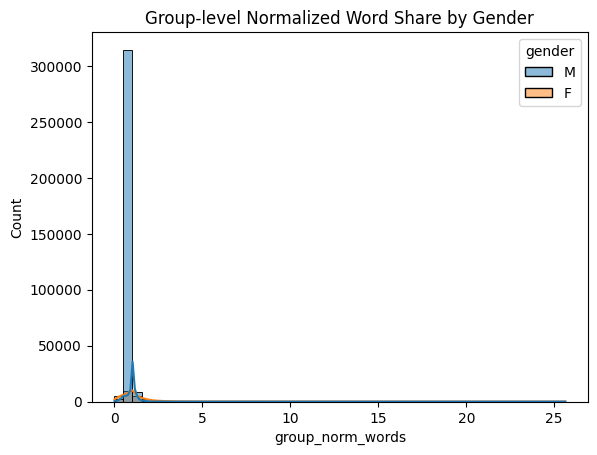

In [9]:
sns.histplot(data=group_df, x="group_norm_words", hue="gender", bins=50, kde=True)
plt.title("Group-level Normalized Word Share by Gender")
plt.show()

### 4.2 Share of words over time (group-level, aggregate)

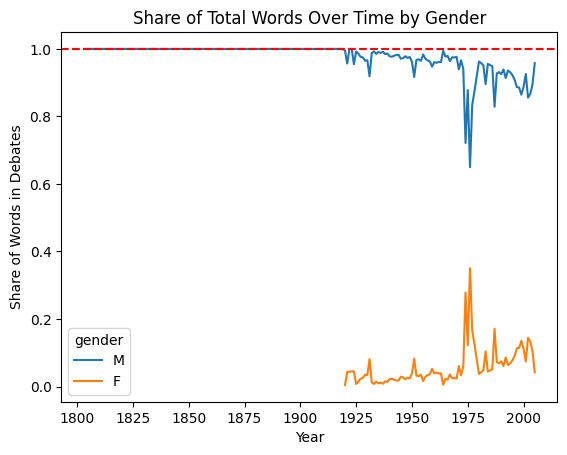

In [10]:
if "year" in group_df.columns:
    df_yearly = (group_df.groupby(["year", "gender"])["observed_words"].sum().reset_index())
    total_by_year = df_yearly.groupby("year")["observed_words"].transform("sum")
    df_yearly["share"] = df_yearly["observed_words"] / total_by_year

    sns.lineplot(x="year", y="share", hue="gender", data=df_yearly)
    plt.title("Share of Total Words Over Time by Gender")
    plt.xlabel("Year")
    plt.ylabel("Share of Words in Debates")
    plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
    plt.show()

### 4.3 Total observed words by gender

/var/folders/0m/grfzmmms0559g5xz0whbn8180000gn/T/ipykernel_57019/2316999920.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


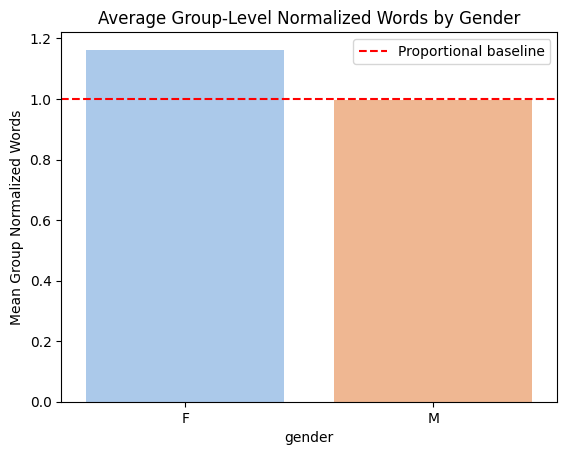

In [20]:
words_by_gender = (
    group_df.groupby("gender")["group_norm_words"]
    .mean()  # average normalized share per debate
    .reset_index()
)

sns.barplot(
    x="gender", y="group_norm_words", data=words_by_gender,
    palette="pastel"
)
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.title("Average Group-Level Normalized Words by Gender")
plt.ylabel("Mean Group Normalized Words")
plt.legend()
plt.show()


### 4.4 Raw total words by gender (No normalization)

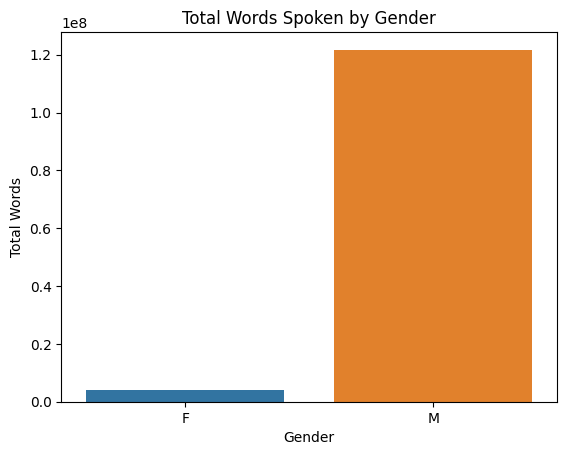

In [ ]:
words_by_gender = group_df.groupby("gender")["observed_words"].sum().reset_index()

sns.barplot(x="gender", y="observed_words", hue='gender', data=words_by_gender)
plt.title("Total Words Spoken by Gender")
plt.xlabel("Gender")
plt.ylabel("Total Words")
plt.show()

## 5. Flat Normalization

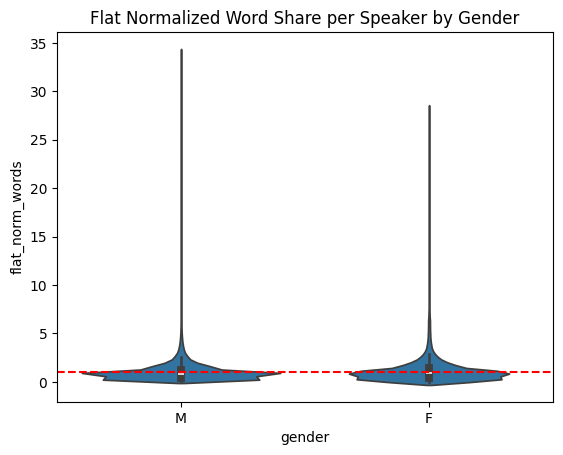

In [12]:
sns.violinplot(x="gender", y="flat_norm_words", data=speaker_df[speaker_df["speaker"].notna()])
plt.title("Flat Normalized Word Share per Speaker by Gender")
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.show()

## 6. Average Words per Turn

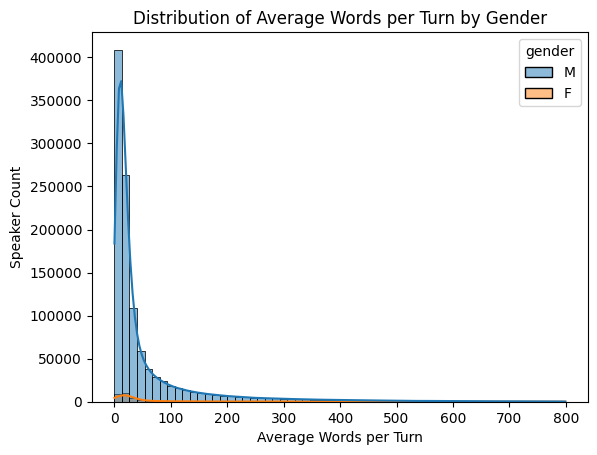

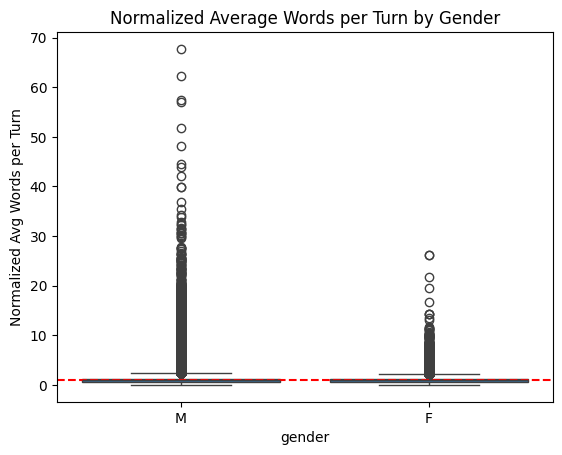

In [13]:
sns.histplot(data=speaker_df[(speaker_df["speaker"].notna()) & (speaker_df["avg_words_per_turn"]<800)], x="avg_words_per_turn", hue="gender", kde=True, bins=60)
plt.title("Distribution of Average Words per Turn by Gender")
plt.xlabel("Average Words per Turn")
plt.ylabel("Speaker Count")
plt.show()


sns.boxplot(x="gender", y="norm_avg_words_per_turn", data=speaker_df[speaker_df["speaker"].notna()])
plt.title("Normalized Average Words per Turn by Gender")
plt.ylabel("Normalized Avg Words per Turn")
plt.axhline(1, color="red", linestyle="--", label="Proportional baseline")
plt.show()

## 7. Distinctive Vocabulary

### 7.1 Top Unique Words by Gender

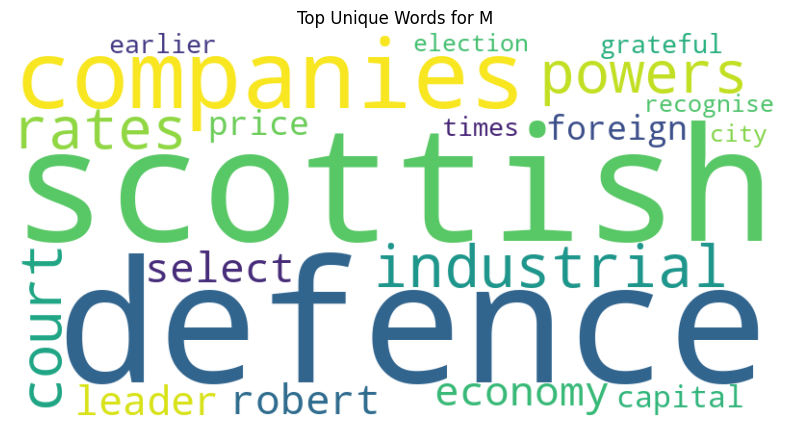

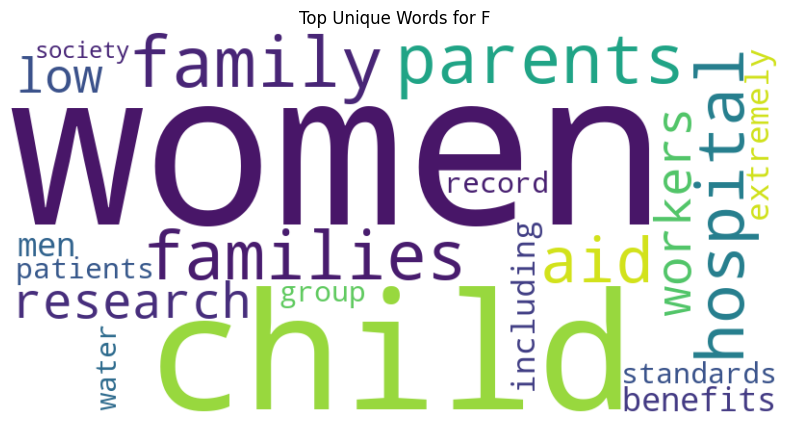

In [14]:
# If you have a dict of unique words saved separately:
try:
    for gender in ["M", "F"]:
        subset = words_df[words_df["gender"] == gender]
        if subset.empty:
            continue

        words_dict = dict(zip(subset["word"], subset["count"]))
        wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words_dict)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Top Unique Words for {gender}")
        plt.show()

except Exception as e:
    print("Unique word cloud section skipped:", e)

### 7.2 Top 20 distinctive words by gender

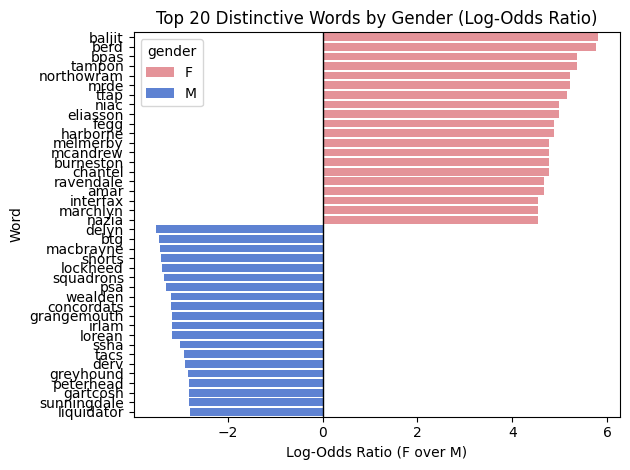

In [15]:
# Take top and bottom 20 words by log-odds
top_f = logodds_df.sort_values("log_odds_f_over_m", ascending=False).head(20)
top_m = logodds_df.sort_values("log_odds_f_over_m", ascending=True).head(20)

top_words = pd.concat([
    top_f.assign(gender="F"),
    top_m.assign(gender="M")
])

sns.barplot(
    data=top_words,
    x="log_odds_f_over_m", y="word",
    hue="gender", dodge=False,
    palette={"M":"#4B7BE5","F":"#F2858D"}
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 20 Distinctive Words by Gender (Log-Odds Ratio)")
plt.xlabel("Log-Odds Ratio (F over M)")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

### 7.3 Frequency vs distinctiveness scatter

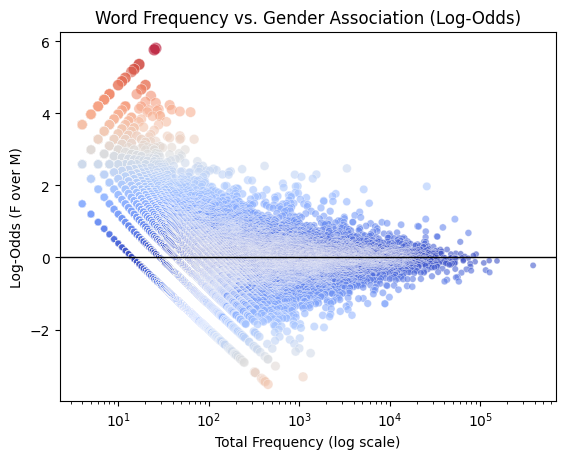

In [16]:
logodds_df["abs_log_odds"] = logodds_df["log_odds_f_over_m"].abs()
logodds_df["total_freq"] = logodds_df["freq_m"] + logodds_df["freq_f"]

sns.scatterplot(
    data=logodds_df,
    x="total_freq",
    y="log_odds_f_over_m",
    hue="abs_log_odds",
    size="abs_log_odds",
    palette="coolwarm",
    alpha=0.6,
    legend=False
)
plt.xscale("log")
plt.axhline(0, color="black", linewidth=1)
plt.title("Word Frequency vs. Gender Association (Log-Odds)")
plt.xlabel("Total Frequency (log scale)")
plt.ylabel("Log-Odds (F over M)")
plt.show()

### 7.4 Histogram of log-odds values

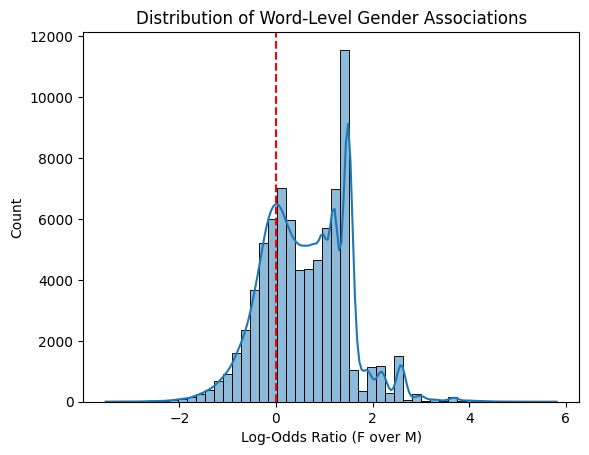

In [17]:
sns.histplot(logodds_df["log_odds_f_over_m"], bins=50, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of Word-Level Gender Associations")
plt.xlabel("Log-Odds Ratio (F over M)")
plt.show()

## 8. Comparison: Turns vs Words

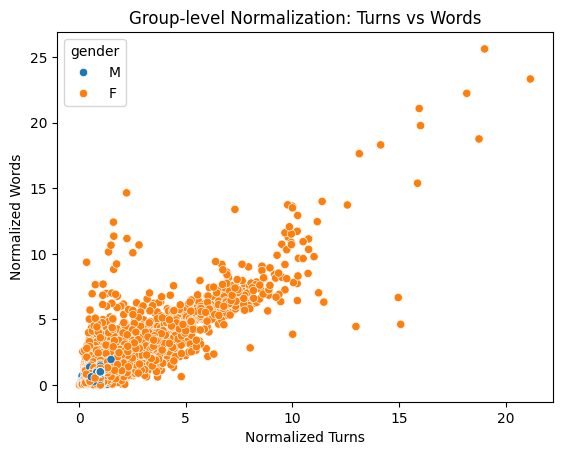

In [18]:
# If you have turn_frequency parquet for comparison:
try:
    turns_df = pd.read_parquet("/Users/msawkar/Projects/hansard-nlp-explorer/src/hansard/data/analysis_data/attention_turn_freq_group.parquet")
    merged = pd.merge(df, turns_df, on=["debate_id", "gender"], suffixes=("_words", "_turns"))


    sns.scatterplot(x="group_norm_turns", y="group_norm_words", hue="gender", data=merged)
    plt.title("Group-level Normalization: Turns vs Words")
    plt.xlabel("Normalized Turns")
    plt.ylabel("Normalized Words")
    plt.show()
except Exception as e:
    print("Turn-word comparison skipped:", e)

## 9. Save Processed Data

In [19]:
# output_path = "processed_word_analysis.parquet"
# df.to_parquet(output_path, index=False)
# print(f"Processed data saved to {output_path}")